In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict

In [3]:
## Parse genetic distance values (from biopython distance matrix, simple/naive identity nt scoring)
divergence = pd.read_csv('/Users/Sidney/Dropbox/dengue/titers_divergence/control_any_distMatrix.csv', header=0, index_col=0)
divergence.fillna(0, inplace=True)

In [27]:
### Parse and normalize titers 
titerfile = open('/Users/Sidney/nextstrain/fauna/data/dengue_titers.tsv', 'r')
titers = defaultdict(lambda: defaultdict(list)) # { serum: {testvirus: [measure1, measure2, ...], testvirus2: [m1,m2...], } }
autologous = defaultdict(list) # { serum: [all raw autologous titer values]}

for line in titerfile:
    virus, serum, serumID, src, val = line.split()
    titers[serum][virus].append(float(val))
    if virus == serum:
        autologous[virus].append(float(val))
titers = dict(titers)

autologous = { serum: np.mean(pd.Series(values).map(np.log2)) 
                              for serum, values in autologous.items() } # Normalize autologous measurements first
no_autologous = []
data = []
for serum, assays in titers.items():
    titers[serum] = dict(titers[serum])
    if serum not in assays:
        print 'no autologous measurement for %s'%serum # Skip and later discard strains with no autologous measurement available
        no_autologous.append(serum)
        continue
    else:
        for virus, values in sorted(assays.items()): # Convert to mean of log2 titer measurements, normalize to autologous titers
            normalized_titer = np.mean(pd.Series(values).map(np.log2)) - autologous[serum]
            titers[serum][virus] = normalized_titer
            serum_sero, virus_sero = serum.split('/')[0], virus.split('/')[0]
            if serum_sero == virus_sero:
                serotype = serum_sero
            else:
                serotype = 'heterologous'
            if serum in autologous and virus in autologous:
                try:
                    distance = divergence.at[serum, virus] # Symmetric
                except:
                    distance = divergence.at[virus, serum]
                data.append({'serum': serum, 'virus': virus, 'serotype':serotype, 'titer': normalized_titer, 'distance': distance})
data = pd.DataFrame(data, columns = ['serum', 'virus', 'serotype', 'distance', 'titer'])
print data.head()
print pd.value_counts(data['serotype'])

no autologous measurement for DENV1/BOLIVIA/FSB3363/2010
no autologous measurement for DENV1/PERU/IQT6152/2000
no autologous measurement for DENV3/MYANMAR/80931/2008
no autologous measurement for DENV4/MYANMAR/81087/2008
no autologous measurement for DENV2/CAMBODIA/D2T0601085/2009
no autologous measurement for DENV1/VENEZUELA/OBT1298/2000
                      serum                           virus      serotype  \
0  DENV3/CAMBODIA/AC23/2011        DENV1/MYANMAR/61117/2005  heterologous   
1  DENV3/CAMBODIA/AC23/2011  DENV1/PUERTO_RICO/BIDV852/2006  heterologous   
2  DENV3/CAMBODIA/AC23/2011         DENV2/PERU/IQT2913/1996  heterologous   
3  DENV3/CAMBODIA/AC23/2011         DENV2/SENEGAL/0674/1970  heterologous   
4  DENV3/CAMBODIA/AC23/2011        DENV2/TONGA/DELTA30/1974  heterologous   

   distance     titer  
0  0.040632 -2.106915  
1  0.892603 -1.347923  
2  0.894912 -2.222392  
3  0.898606  0.321928  
4  0.898513 -2.347923  
heterologous    176
DENV2            70
DENV3       

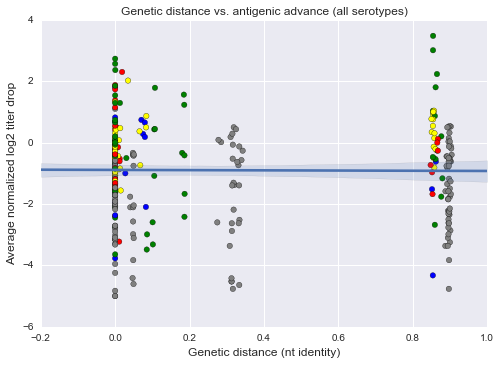

In [29]:
fig, ax = plt.subplots()
colors = { 'DENV1': 'blue', 'DENV2': 'green', 'DENV3': 'yellow', 'DENV4': 'red', 'heterologous': 'gray'}
plt.scatter(data['distance'], data['titer'], c=[ colors[s] for s in data['serotype'] ], s=30, cmap='viridis')
sns.regplot('distance', 'titer', data=data, scatter=False)

ax.set_xlabel('Genetic distance (nt identity)', size=12)
ax.set_ylabel('Average normalized log2 titer drop', size=12)
ax.set_title('Genetic distance vs. antigenic advance (all serotypes)', size=12)